In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.applications import MobileNet, Xception, ResNet50, InceptionV3
from tensorflow.keras.layers import Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [1]:
import os
import numpy as np
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')

In [2]:
!pip install kaggle
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bananapple","key":"20fb6b8f4a62f473137bd0700db9a067"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning 방지
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d tongpython/cat-and-dog

100% 217M/218M [00:11<00:00, 22.5MB/s]
100% 218M/218M [00:11<00:00, 20.7MB/s]


In [5]:
#압축풀기
import zipfile

local_zip = '/content/cat-and-dog.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/content/cat and dog')
zip_ref.close()

# 경로설정

In [6]:
train_dir='/content/cat and dog/training_set/training_set'

test_dir='/content/cat and dog/test_set/test_set'

# 데이터셋 전처리

In [7]:
IMG_WIDTH=250
IMG_HEIGHT=250

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator #ImageDataGenerator는 이미지를 읽어올 때 rescale을 통해 자동으로 정규화시켜준다.

train_data_gen=ImageDataGenerator(rescale=1./255,
                                  rotation_range=10,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.1,
                                  zoom_range=0.1)

test_data_gen=ImageDataGenerator(rescale=1./255)


train_data=train_data_gen.flow_from_directory(train_dir,
                                              batch_size=32,
                                              color_mode='rgb',
                                              shuffle=True,
                                              class_mode='sparse',#categorical은 정답이 one-hot encoding방식으로 정의된다.
                                              target_size=(IMG_WIDTH,IMG_HEIGHT)
                                              )
#각 경로 train_dir에서 32개씩 categorical모드로 color이미지에 위 ImageDataGenerator를 이용해 다양하게 이미지를 옆으로도 돌리고 가로 세로도 늘리고 등등해서 읽어들인다는걸 알 수 있음
test_data=test_data_gen.flow_from_directory(test_dir,
                                            batch_size=32,
                                            color_mode='rgb',
                                            shuffle=True,
                                            class_mode='sparse',
                                            target_size=(IMG_WIDTH,IMG_HEIGHT)
                                            )


Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


In [ ]:
#정답확인(y값)
print(train_data.class_indices.items())

print(test_data.class_indices.items())

#class_indices는 문자열로 표시되는 데이터의 정답이 어떤 숫자로 매칭되어 있는지 확인할 수 있음
#정답을 보면 cats은 y값이 0으로 dogs는 y값이 1로 되어있다.

dict_items([('cats', 0), ('dogs', 1)])
dict_items([('cats', 0), ('dogs', 1)])


# 전이학습을 위한 모델 구축

In [ ]:
base_model=Xception(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH,IMG_HEIGHT,3))
#pre model로 Xception을 사용했고
#weights는 사전학습에 사용된 데이터셋으로 imagenet 데이터셋을 사용했고
#include_top=false는 사전학습 모델에서 특징추출기만 가져오겠다는 뜻 
#즉 여기서는 Xception 모델을 특징추출기로만 사용하겠다는 뜻이다.

model=Sequential()

model.add(base_model)

model.add(GlobalAveragePooling2D())

#새로운 분류기
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.25))                  
model.add(Dense(2, activation='softmax'))

model.summary()

83683744/83683744 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 16)                32784     
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 34

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(2e-5),
              metrics='accuracy'
              )
#optimizer=tf.keras.optimizers.Adam(2e-5)의 의미는 
#전이학습에서 fine-tuning은 학습률(learning rate)를 낮게 설정해서 우리가 사용하는 사전학습모델의 가중치를 조금씩조금씩 업데이트해주는 것이 핵심

# 학습하기

In [ ]:
from datetime import datetime
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

save_file_name='./cats_and_dogs_filltered_Xception_colab.h5'

chekpoint= ModelCheckpoint(save_file_name, #파일명 지정
                           monitor='val_loss', #val_loss 값이 개선되었을때 checkpoint 호출하기
                           verbose=2, 
                           save_bset_only=True, #bset값만 저장
                           mode='auto' #auot는 알아서 best를 찾아 준다.
                           )
earlystopping=EarlyStopping(monitor='val_loss', #val_loss 값이 개선되었을 때
                            patience=5 #5회 epoch 동안 val_loss가 개선되지 않는다면 종료
                            )

In [ ]:
history=model.fit(train_data, 
                  epochs=5, 
                  validation_data=test_data, 
                  callbacks=[chekpoint, earlystopping]
                  )

Epoch 1/5
251/251 [==============================] - ETA: 0s - loss: 0.2020 - accuracy: 0.9518
Epoch 1: saving model to ./cats_and_dogs_filltered_Xception_colab.h5
251/251 [==============================] - 229s 847ms/step - loss: 0.2020 - accuracy: 0.9518 - val_loss: 0.0311 - val_accuracy: 0.9906
Epoch 2/5
251/251 [==============================] - ETA: 0s - loss: 0.0464 - accuracy: 0.9894
Epoch 2: saving model to ./cats_and_dogs_filltered_Xception_colab.h5
251/251 [==============================] - 209s 830ms/step - loss: 0.0464 - accuracy: 0.9894 - val_loss: 0.0242 - val_accuracy: 0.9911
Epoch 3/5
251/251 [==============================] - ETA: 0s - loss: 0.0248 - accuracy: 0.9939
Epoch 3: saving model to ./cats_and_dogs_filltered_Xception_colab.h5
251/251 [==============================] - 209s 831ms/step - loss: 0.0248 - accuracy: 0.9939 - val_loss: 0.0258 - val_accuracy: 0.9901
Epoch 4/5
251/251 [==============================] - ETA: 0s - loss: 0.0202 - accuracy: 0.9956
Epoch 4:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#모델 저장하기
from keras.models import load_model
model.save('강아지vs고양이.h5')

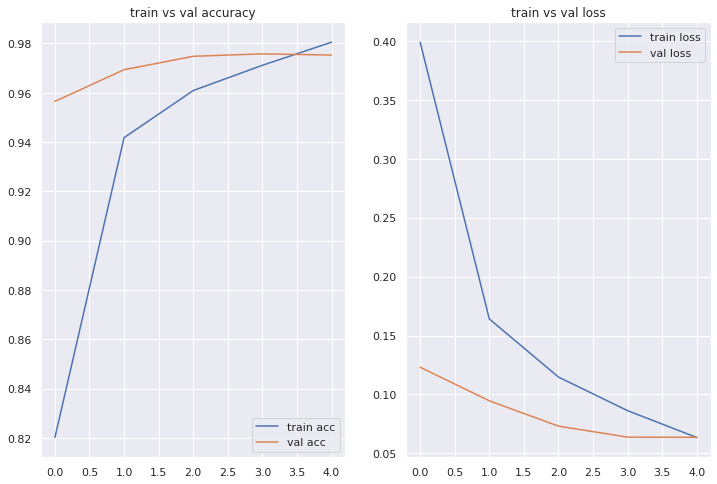

In [ ]:
#정확도
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

#오차 확인
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(5)

#accuracy 확인
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='train acc')
plt.plot(epochs_range,val_acc,label='val acc')
plt.legend(loc='lower right')
plt.title('train vs val accuracy')

#오차 확인
plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='train loss')
plt.plot(epochs_range,val_loss,label='val loss')
plt.legend()
plt.title('train vs val loss')

plt.show()

# 모델불러오기

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/데이터저장/모델저장/강아지vs고양이.h5')

In [12]:
#test데이터 정확도 확인
test_loss, test_acc = model.evaluate(test_data,verbose=2)#verbose는 그냥 출력문을 어떤식으로 보여줄까 묻는거 0은 출력문 안보여줌 1은 반만 2는 전체 다 출력

print('\n테스트 정확도:', test_acc)
print('\n테스트 손실값"',test_loss)

64/64 - 19s - loss: 0.0239 - accuracy: 0.9916 - 19s/epoch - 297ms/step

테스트 정확도: 0.9915966391563416

테스트 손실값" 0.023871412500739098


# 시각화

In [ ]:
# https://www.youtube.com/watch?v=fAgTGrcKE2E&t=599s

#위 영상 참고

In [ ]:
# https://github.com/neowizard2018/neowizard/blob/master/TensorFlow2/TF_2_x_LEC_27_TransferLearning_Example.ipynb

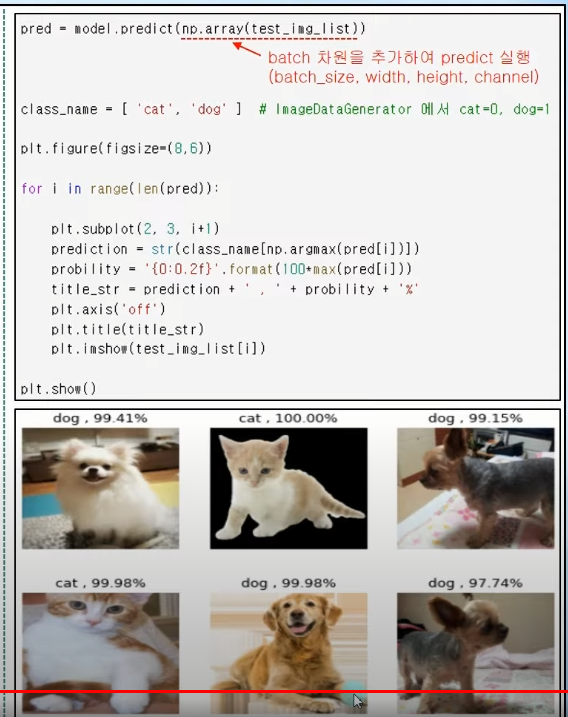

In [ ]:
import cv2
import glob

test_img_list=[]

test_img_name_list=glob.glob('test_image_dir/*')

for i in range(len(test_img_name_list)):
    src_img = cv2.imread(test_img_name_list[i], cv2.IMREAD_COLOR)
    src_img = cv2.resize(src_img, dsize=(IMG_WIDTH, IMG_HEIGHT))
    src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)
    src_img = src_img / 255.0

    test_img_list.append(src_img)


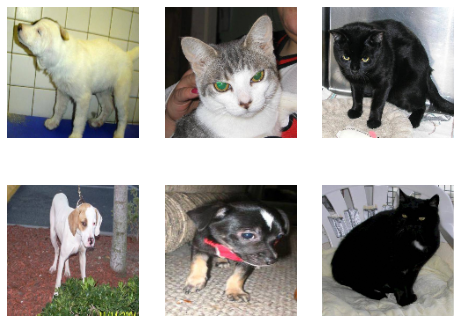

In [ ]:
plt.figure(figsize=(8,6))

for i in range(len(test_img_list)):
  plt.subplot(2,3,i+1)
  plt.axis('off')
  plt.imshow(test_img_list[i])

plt.show()

In [ ]:
for i in range(len(test_img_list)):
  print(test_img_list[i].shape)

(150, 150, 3)
(150, 150, 3)
(150, 150, 3)
(150, 150, 3)
(150, 150, 3)
(150, 150, 3)


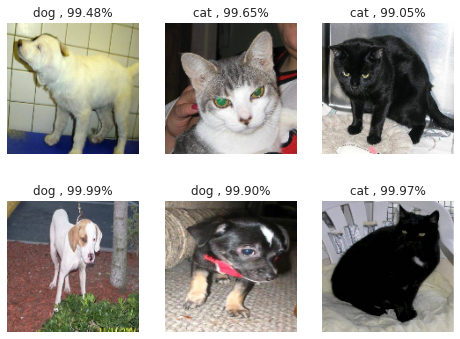

In [ ]:
pred=model.predict(np.array(test_img_list))

calass_name=['cat','dog']

plt.figure(figsize=(8,6))

for i in range(len(test_img_list)):
  plt.subplot(2,3,i+1)
  prediction=str(calass_name[np.argmax(pred[i])])
  #probility='{0:0.2f}'.format(max(pred[i]))
  probility='{0:0.2f}'.format(100*max(pred[i]))
  title_str=prediction+' , '+probility+'%'
  plt.axis('off')
  plt.title(title_str)
  plt.imshow(test_img_list[i])
plt.show()

[[5.2206409e-03 9.9477935e-01]
 [9.9654621e-01 3.4538074e-03]
 [9.9047172e-01 9.5283352e-03]
 [5.6492605e-05 9.9994349e-01]
 [9.8206755e-04 9.9901795e-01]
 [9.9967957e-01 3.2039935e-04]]
